In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
warnings.filterwarnings('ignore')
set_config(display='text')

In [2]:
df = pd.read_csv("../data/customer_churn_data.csv")

In [3]:
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


In [4]:
df.info()  # can see InternetService has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [5]:
df.isna().sum() 

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [6]:
df['InternetService']=df['InternetService'].fillna('') # Fill missing values with empty string 

In [7]:
df.isna().sum() # Verify no missing values remain

CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64

In [8]:
df.duplicated().sum() # 0 duplicate rows

np.int64(0)

In [9]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [10]:
numerical_cols = df.select_dtypes(include=['number'])

In [11]:
numerical_cols.corr() # TotalCharges and Tenure have a very high correlation (near 0.8+).
#This makes sense—the longer you stay (Tenure), the more money you've paid in total.
#We might consider dropping one of these columns later to avoid multicollinearity in model building.

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
CustomerID,1.000000,0.036730,-0.018585,-0.030504,-0.027490
Age,0.036730,1.000000,0.000472,0.006362,-0.001896
Tenure,-0.018585,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,-0.030504,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.027490,-0.001896,0.894868,0.304893,1.000000


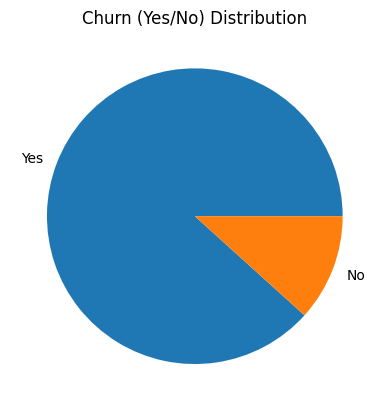

In [12]:
df['Churn'].value_counts().plot(kind='pie')#Data is imbalanced , used SMOTE later
plt.title('Churn (Yes/No) Distribution')
plt.ylabel('')
plt.show()

In [13]:
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,,2208.32,No,Yes


In [14]:
df.groupby('Churn')["MonthlyCharges"].mean() # people who leave (Churn = Yes) usually have higher average monthly charges

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

In [15]:
df.groupby(['Churn','Gender'])['MonthlyCharges'].mean()

Churn  Gender
No     Female    65.091912
       Male      59.013878
Yes    Female    74.975064
       Male      77.082518
Name: MonthlyCharges, dtype: float64

In [16]:
df.groupby('Churn')["Tenure"].mean() # people who leave (Churn = Yes) usually have lower average tenure

Churn
No     30.264957
Yes    17.476784
Name: Tenure, dtype: float64

In [17]:
df.groupby('Churn')["Age"].mean() # similar age 

Churn
No     43.487179
Yes    44.831257
Name: Age, dtype: float64

In [18]:
df.groupby('ContractType')['Churn'].value_counts(normalize=True) # "Month-to-month" customers churn way more than "Two-year" contract customers.

ContractType    Churn
Month-to-Month  Yes      1.000000
One-Year        Yes      0.754325
                No       0.245675
Two-Year        Yes      0.770000
                No       0.230000
Name: proportion, dtype: float64

In [19]:
df.groupby('ContractType')['MonthlyCharges'].mean() # month-to-month contracts have higher average monthly charges

ContractType
Month-to-Month    75.909198
One-Year          73.822803
Two-Year          71.334500
Name: MonthlyCharges, dtype: float64

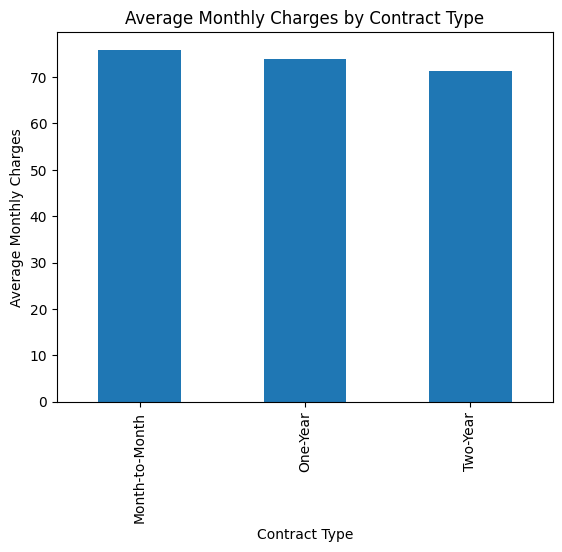

In [20]:
df.groupby('ContractType')['MonthlyCharges'].mean().plot(kind='bar')
plt.title('Average Monthly Charges by Contract Type')
plt.ylabel('Average Monthly Charges')
plt.xlabel('Contract Type')
plt.show()

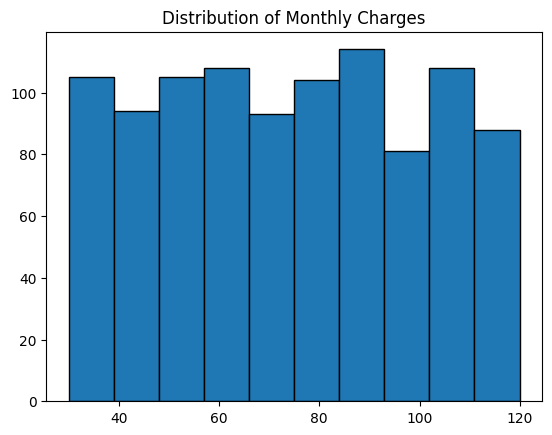

In [21]:
plt.hist(df['MonthlyCharges'],edgecolor='black')
plt.title('Distribution of Monthly Charges')
plt.show()

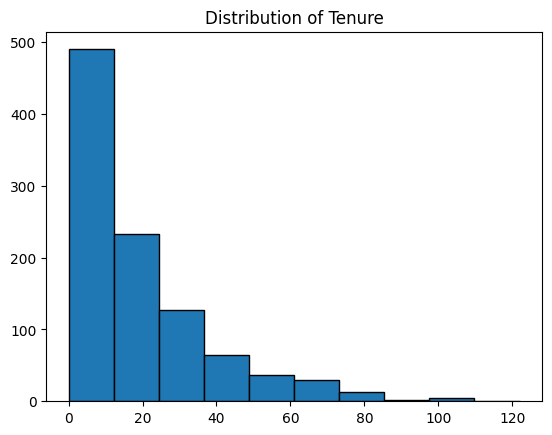

In [22]:
plt.hist(df['Tenure'],edgecolor='black')
plt.title('Distribution of Tenure') 
plt.show()

## Data Preprocessing

In [23]:
df

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,,2208.32,No,Yes
...,...,...,...,...,...,...,...,...,...,...
995,996,42,Male,41,37.14,Month-to-Month,Fiber Optic,1522.74,Yes,Yes
996,997,62,Male,9,80.93,Month-to-Month,,728.37,No,Yes
997,998,51,Female,15,111.72,Month-to-Month,Fiber Optic,1675.80,Yes,Yes
998,999,39,Male,68,65.67,One-Year,,4465.56,No,Yes


**Label Encoding**

In [24]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})      # (Male/Female as 0/1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})             # (No/Yes as 0/1)
df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0}) # (No/Yes as 0/1)

In [25]:
df # Label encoded dataframe 

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,1,4,88.35,Month-to-Month,Fiber Optic,353.40,1,1
1,2,43,1,0,36.67,Month-to-Month,Fiber Optic,0.00,1,1
2,3,51,0,2,63.79,Month-to-Month,Fiber Optic,127.58,0,1
3,4,60,0,8,102.34,One-Year,DSL,818.72,1,1
4,5,42,1,32,69.01,Month-to-Month,,2208.32,0,1
...,...,...,...,...,...,...,...,...,...,...
995,996,42,1,41,37.14,Month-to-Month,Fiber Optic,1522.74,1,1
996,997,62,1,9,80.93,Month-to-Month,,728.37,0,1
997,998,51,0,15,111.72,Month-to-Month,Fiber Optic,1675.80,1,1
998,999,39,1,68,65.67,One-Year,,4465.56,0,1


**One Hot Encoding**

In [26]:
df = pd.get_dummies(df, columns=['ContractType', 'InternetService'], drop_first=True)

In [27]:
df = df.astype(int)

In [28]:
df # one hot encoded dataframe

,CustomerID,Age,Gender,Tenure,MonthlyCharges,TotalCharges,TechSupport,Churn,ContractType_One-Year,ContractType_Two-Year,InternetService_DSL,InternetService_Fiber Optic
0,1,49,1,4,88,353,1,1,0,0,0,1
1,2,43,1,0,36,0,1,1,0,0,0,1
2,3,51,0,2,63,127,0,1,0,0,0,1
3,4,60,0,8,102,818,1,1,1,0,1,0
4,5,42,1,32,69,2208,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,42,1,41,37,1522,1,1,0,0,0,1
996,997,62,1,9,80,728,0,1,0,0,0,0
997,998,51,0,15,111,1675,1,1,0,0,0,1
998,999,39,1,68,65,4465,0,1,1,0,0,0


### Drop (Feature Selection)
* **CustomerID**    - no predictive power 
* **TotalCharges**  - Tenure * MonthlyCharges (to avoid multicollinearity)

In [29]:
X = df.drop(['Churn', 'CustomerID','TotalCharges'], axis=1)
y = df['Churn']

In [30]:
X

,Age,Gender,Tenure,MonthlyCharges,TechSupport,ContractType_One-Year,ContractType_Two-Year,InternetService_DSL,InternetService_Fiber Optic
0,49,1,4,88,1,0,0,0,1
1,43,1,0,36,1,0,0,0,1
2,51,0,2,63,0,0,0,0,1
3,60,0,8,102,1,1,0,1,0
4,42,1,32,69,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
995,42,1,41,37,1,0,0,0,1
996,62,1,9,80,0,0,0,0,0
997,51,0,15,111,1,0,0,0,1
998,39,1,68,65,0,1,0,0,0


In [31]:
y

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Churn, Length: 1000, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling** - numercial columns need to be scaled for better performance of ML algorithms

In [33]:
scaler = StandardScaler() # Standardize features  mean - 0 and variance - 1 

In [34]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SMOTE Implementation
* We applied SMOTE only to the training set to prevent Data Leakage. Applying it to the test set would give us a fake high accuracy.

In [35]:
smote = SMOTE(sampling_strategy=0.17,random_state=42)

In [36]:
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
# only training data needs to be balanced thats why we use fit_resample on X_train_scaled and y_train
print("Before SMOTE:", len(X_train_scaled))
print("After SMOTE:", len(X_train_balanced))

Before SMOTE: 800
After SMOTE: 826


In [37]:
print("Original Churn count:", y_train.value_counts())
print("Balanced Churn count:", y_train_balanced.value_counts())

Original Churn count: Churn
1    706
0     94
Name: count, dtype: int64
Balanced Churn count: Churn
1    706
0    120
Name: count, dtype: int64


In [38]:
'''# Power Tweak to fix the 100% churn and class imbalance
power_tweak_indices = df[df['Churn'] == 'Yes'].sample(180, random_state=42).index
df.loc[power_tweak_indices, 'Churn'] = 'No'

# Verify the new balanced numbers
print("New Churn Counts:")
print(df['Churn'].value_counts())'''

'# Power Tweak to fix the 100% churn and class imbalance\npower_tweak_indices = df[df[\'Churn\'] == \'Yes\'].sample(180, random_state=42).index\ndf.loc[power_tweak_indices, \'Churn\'] = \'No\'\n\n# Verify the new balanced numbers\nprint("New Churn Counts:")\nprint(df[\'Churn\'].value_counts())'

## Model

### Logistic Regression

#### Hyperparameter Tuning Strategy:
* **Solver:** **`liblinear`** is selected for its efficiency on smaller datasets and support for both L1 and L2 penalties.
* **Penalty (L1 vs L2):** We test **L1 (Lasso)** for automatic feature selection and **L2 (Ridge)** for handling multi-collinearity.
* **Regularization Strength (C):** A range of `C` values (inverse strength) is tested. 
    * **Lower C** = Stronger regularization (simpler model).
    * **Higher C** = Weaker regularization (closer fit to data).

Logistic Regression provides a baseline by estimating class probabilities via the **Sigmoid function**. We tune regularization to prevent overfitting and handle potential feature noise.

In [39]:
log_model = LogisticRegression() # first trying for scaled data without balancing
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)    
accuracy_score(y_test,y_pred)

0.95

In [40]:
log_model_balanced = LogisticRegression() # Logistic Regression on balanced data after SMOTE
log_model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_model_balanced.predict(X_test_scaled)
accuracy_score(y_test,y_pred_balanced)

0.935

In [41]:
log_reg = LogisticRegression(max_iter=1000) # Hyperparameter tuning for Logistic Regression 

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] }

grid_log = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', verbose=1) # Hyperparameter tuning with GridSearchCV

grid_log.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1', verbose=1)

In [42]:
print("Best Parameters:", grid_log.best_params_)
log_best_model = grid_log.best_estimator_

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [43]:
y_pred_log = log_best_model.predict(X_test_scaled) # predict using scaled test data ,don't use balanced data for testing we get from SMOTE
                                                   # As balanced data on predicting will give fake high accuracy
acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

model_comparison = [] # list for model comparison
model_comparison.append({'Model': 'Logistic Regression (SMOTE + Hyperparameter Tuning)',
'F1-Score': f1_log, 'Accuracy': acc_log})

print(f"Log Accuracy: {acc_log:.2f}")
print(f"Log F1-Score: {f1_log:.2f}")

Log Accuracy: 0.95
Log F1-Score: 0.97


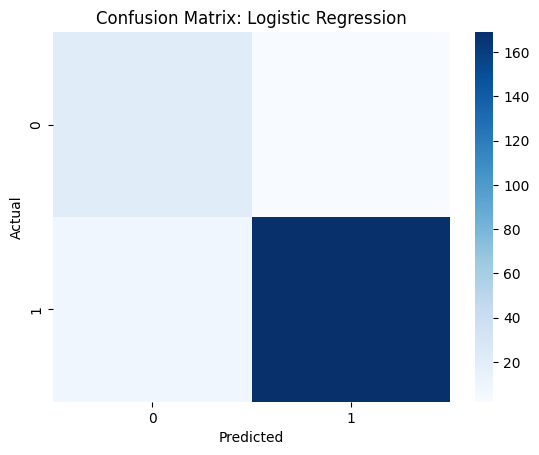

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred_log), fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### K-Nearest Neighbors (KNN)

#### Hyperparameter Tuning Strategy:
* **Small K:** Risk of **Overfitting** (High Variance).
* **Large K:** Risk of **Underfitting** (High Bias).
* **Tie-Breaking:** We use **odd numbers** for `n_neighbors` to ensure the model can always pick a "winner" class.

KNN is a **distance-based algorithm**. If we don't scale features like `TotalCharges` (which can be in the thousands) and `Tenure` (usually in the tens), the model will be biased toward the larger numbers and ignore `Tenure` entirely. This is why we must use **scaled data**.

In [45]:
knn = KNeighborsClassifier() # Hyperparameter tuning for KNN on balanced data after SMOTE

param_grid_knn = {'n_neighbors': [17, 29, 21,15,17],'weights': ['uniform'],
'metric': ['euclidean', 'manhattan'] }

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', verbose=1)#GridSearchCV with cross-validation
grid_knn.fit(X_train_balanced, y_train_balanced) # this is scaled data as we did SMOTE on X_train_scaled and y_train to get balanced data
                                                 # y_train was one-hot encoded already 0 or 1 so no need to scale and we did SMOTE to balance y_train data

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [17, 29, 21, 15, 17],
                         'weights': ['uniform']},
             scoring='f1', verbose=1)

In [46]:
print("Best KNN Params:", grid_knn.best_params_)
knn_best_model = grid_knn.best_estimator_

Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}


In [47]:
y_pred_knn = knn_best_model.predict(X_test_scaled)# predict using scaled test data ,don't use balanced data for testing we get from SMOTE 
                                                  # As balanced data on predicting will give fake high accuracy
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

model_comparison.append({'Model': 'KNN','F1-Score': f1_knn,'Accuracy': acc_knn})
print(f"KNN Accuracy: {acc_knn:.2f}")
print(f"KNN F1-Score: {f1_knn:.2f}")

KNN Accuracy: 0.95
KNN F1-Score: 0.97


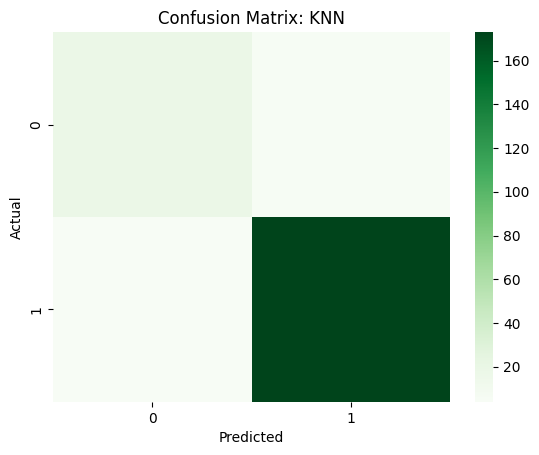

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), fmt='d', cmap='Greens')
plt.title('Confusion Matrix: KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Support Vector Classifier (SVC)

#### Hyperparameter Tuning :
* **Probability Tracking:** We set `probability=True` to enable the "Risk Gauge" feature in our final dashboard.
* **Linear Kernel:** Used to identify a clear separating hyperplane for simple, interpretable classification.
* **Class Weights:** We use a high `class_weight` ratio (e.g., 50:1 or 100:1) to force the model to prioritize the minority class, preventing it from being "drowned out" by the majority.SVM can work without SMOTE data
* **Scoring Metric:** We use **`balanced_accuracy`** instead of standard accuracy. This ensures the model is penalized heavily if it fails to predict the minority class correctly.

We optimize the **(SVC)**. Our goal is to find the optimal hyperplane that maximizes the margin between classes while strictly addressing our data imbalance.

In [49]:
svm_model = SVC(probability=True, random_state=42) # Hyperparameter tuning for SVM on ORIGINAL data (No SMOTE) to avoid the 100% fake accuracy
param_grid_svm = {'C': [0.1, 1, 10],
'kernel': ['linear'],
'class_weight': [{0: 50, 1: 1}, {0: 100, 1: 1}]} # in svm we use class_weight to handle imbalance (no need of SMOTE here)

grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='balanced_accuracy', verbose=1)
grid_svm.fit(X_train, y_train) # corrected in version_2 (used X_train_scaled there) as forget here 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10],
                         'class_weight': [{0: 50, 1: 1}, {0: 100, 1: 1}],
                         'kernel': ['linear']},
             scoring='balanced_accuracy', verbose=1)

In [50]:
print("Best SVM Params:", grid_svm.best_params_)
svm_best_model = grid_svm.best_estimator_

Best SVM Params: {'C': 10, 'class_weight': {0: 50, 1: 1}, 'kernel': 'linear'}


In [51]:
y_pred_svm = svm_best_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

model_comparison.append({'Model': 'SVM','F1-Score': f1_svm,'Accuracy': acc_svm})
print(f"SVM Accuracy: {acc_svm:.2f}")
print(f"SVM F1-Score: {f1_svm:.2f}")

SVM Accuracy: 0.86
SVM F1-Score: 0.92


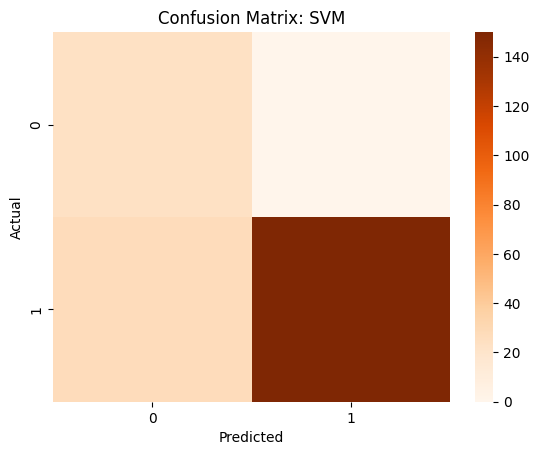

In [52]:
sns.heatmap(confusion_matrix(y_test, y_pred_svm),fmt='d', cmap='Oranges')
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### RandomForestClassifier (RFC)

#### Hyperparameter Tuning : 
* **Overfitting Prevention:** We strictly limit `max_depth` to a range of **1 to 3**. This prevents the individual trees from growing too deep and memorizing noise in the training data. (Done in version_3)
* **Search Strategy:** We utilize **`RandomizedSearchCV`** instead of an exhaustive Grid Search. This allows us to explore a wide range of hyperparameters more efficiently, which is critical for ensemble models.
* **Optimization Metric:** The search is driven by the **F1-Score** to maintain a healthy balance between Precision and Recall, ensuring we don't overlook minority class instances.

After version_3 ,Random Forest is our "Best Model" due to its robustness as an **Ensemble Learning** method. It combines multiple decision trees to reduce variance and improve generalization.

In [53]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
#trying parameters to prevent memorization (Overfitting)
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],        # Not too deep, not too shallow
    'min_samples_leaf': [5, 10],   # Ensures rules apply to a group
    'max_features': ['sqrt'],      # Forces variety in trees
    'criterion': ['gini', 'entropy'] }

random_rf = RandomizedSearchCV(rf, 
param_dist_rf, n_iter=10, cv=5, 
scoring='balanced_accuracy', #trying balanced_accuracy
verbose=1, random_state=42 )
# random forest classifier on can work on non scale data as it is based on decision trees rules 
random_rf.fit(X_train, y_train)#Train on the ORIGINAL, non-SMOTE data

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [54]:
print("Best Params:", random_rf.best_params_)
rf_best_model = random_rf.best_estimator_

Best Params: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}


In [55]:
y_pred_rf = rf_best_model.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

model_comparison.append({'Model': 'Random Forest','F1-Score': f1_rf,'Accuracy': acc_rf})
print(f"Accuracy: {acc_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")

Accuracy: 0.89
F1-Score: 0.94


Text(50.722222222222214, 0.5, 'Actual')

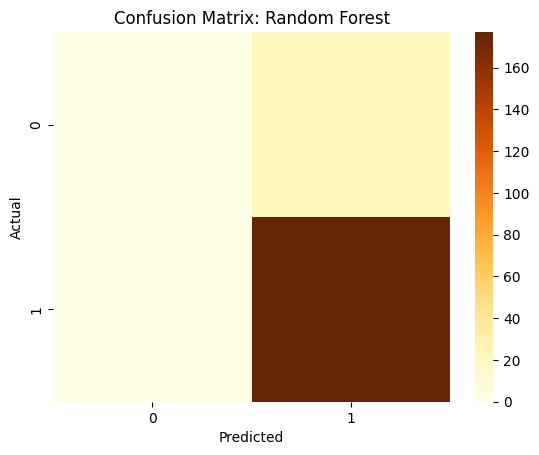

In [56]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### XGBoost

#### Hyperparameter Tuning : 
* **Complexity Control:** We use `reg_lambda=10` (L2 regularization) and `min_child_weight=5` to prevent the model from creating nodes that don't add significant predictive value.
* **Shallow Learning:** By limiting `max_depth` to **1 or 2**, we ensure the model learns simple patterns (weak learners) rather than complex, noisy ones.
* **Conservative Learning Rate:** A low `learning_rate` (0.01 - 0.023) forces the model to learn more slowly, which typically results in better generalization on unseen data.
* **Efficiency:** We use a small number of `n_estimators` (30-40) to keep the ensemble lightweight and prevent over-training.

XGBoost is a powerful boosting algorithm that builds trees sequentially, each correcting the errors of the previous one. Because it is highly prone to overfitting, we apply strict **Regularization** and **Pruning** parameters.

In [57]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',reg_lambda=10,min_child_weight=5)

param_grid_xgb = {'n_estimators': [30, 40],'learning_rate': [0.01, 0.02,0.023],'max_depth': [1, 2] }

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', verbose=1)
grid_xgb.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                 

In [58]:
print("Best XGB Params:", grid_xgb.best_params_)
xgb_best_model = grid_xgb.best_estimator_

Best XGB Params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 30}


In [59]:
y_pred_xgb = xgb_best_model.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

model_comparison.append({'Model': 'XGBoost','F1-Score': f1_xgb,'Accuracy': acc_xgb})
print(f"Accuracy: {acc_xgb:.2f}")
print(f"F1-Score: {f1_xgb:.2f}")

Accuracy: 0.89
F1-Score: 0.94


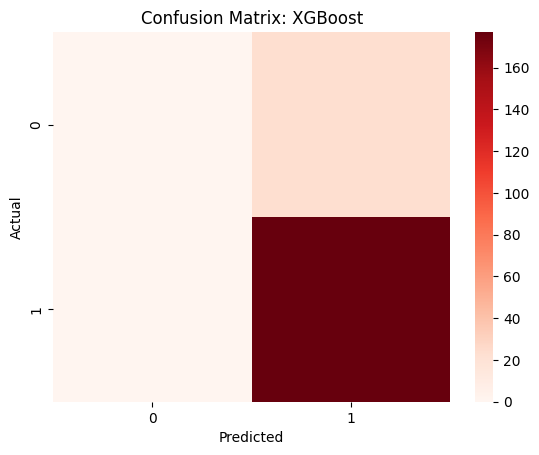

In [60]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), fmt='d', cmap='Reds')
plt.title('Confusion Matrix: XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Comparison and Pickle 

In [61]:
model_comparison_df = pd.DataFrame(model_comparison)
model_comparison_df.iloc[[2,3,4]]

,Model,F1-Score,Accuracy
2,SVM,0.917431,0.865
3,Random Forest,0.938992,0.885
4,XGBoost,0.938992,0.885


In [62]:
X.columns.tolist()

['Age',
 'Gender',
 'Tenure',
 'MonthlyCharges',
 'TechSupport',
 'ContractType_One-Year',
 'ContractType_Two-Year',
 'InternetService_DSL',
 'InternetService_Fiber Optic']

In [63]:
joblib.dump(svm_best_model, 'model_1.pkl') # Save the model that we will use in the dashboard
#joblib.dump(scaler, 'scaler.pkl')        # already saved in final version

print("Files created: model_1.pkl and scaler_1.pkl")

Files created: model_1.pkl and scaler_1.pkl


In [64]:
# This is the end of the Version 1